In [746]:
import shutil
from zipfile import ZipFile as zf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNetCV,LinearRegression
from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV,LeaveOneOut
from sklearn.neural_network import MLPRegressor
from scipy.stats import randint

In [747]:
# unrar
SEED = 101

with zf('Clinic.zip','r') as zin:
    zin.extractall()
    shutil.rmtree('25yjwbphn4-1')

In [748]:
# load data
df = pd.read_csv('Dataset.csv',encoding='utf-8')
medications = pd.read_csv('Medicationkey.csv')

df.rename(columns={'ID': 'Patient'}, inplace=True)
df.set_index('Patient',inplace=True)
medications.set_index('Medication', inplace=True)

# As-is, drug names have been shortened to alphabet letters, let's revert that
old_columns = medications.values.flatten()
new_columns = medications.index

for old, new in zip(old_columns, new_columns):
    df.rename(columns={old: new}, inplace=True)

In [749]:
# Get a sense of what features we are dealing with in this set
df.columns

Index(['GENDER', 'AGE', 'RACE/ETHNICITY', 'Diagnosis', 'MD', 'Assignment',
       'EMR', 'LOS', 'RAR', 'AMITRIPTYLINE', 'ARIPIPRAZOLE', 'ASENAPINE',
       'BUPROPION', 'CHLORPROMAZINE', 'CITALOPRAM', 'CLOMIPRAMINE',
       'CLONIDINE', 'DOXEPIN', 'DULOXETINE', 'ESCITALOPRAM', 'FLUOXETINE',
       'FLUPHENAZINE', 'FLUVOXAMINE', 'GUANFACINE', 'HALOPERIDOL',
       'IMIPRAMINE', 'LITHIUM CARBONATE', 'METHYLPHENIDATE', 'MIRTAZAPINE',
       'NORTRIPTYLINE', 'OLANZAPINE', 'PALIPERIDONE', 'PERPHENAZINE',
       'QUETIAPINE', 'RISPERIDONE', 'SERTRALINE', 'TRAZODONE', 'VENLAFAXINE',
       'ZIPRASIDONE', '# Psychotropic Medications', '# Administrations',
       'Therapeutic Guidances'],
      dtype='object')

In [750]:
# Clean unconventional column names

# This is the equivalent of counting all drug columns suministered to the patient. We will later see how to use this
df.rename(columns={'# Administrations': 'Administrations'}, inplace=True)

df.rename(columns={'# Psychotropic Medications': 'Psychotropics'}, inplace=True)
df.rename(columns={'RACE/ETHNICITY': 'Ethnicity'}, inplace=True)

In [751]:
print('Checking for void values:')
df[df.columns[df.isnull().any()]].isnull().sum()

Checking for void values:


Assignment               41
Therapeutic Guidances    41
dtype: int64

In [752]:
'''
My strategy: 
Fill NaN with the most frequent value for each category
Note: mode() is the same as doing df[c].value_counts().index[0]
'''
df["Assignment"].fillna(df["Assignment"].mode().iloc[0], inplace=True)
df["Therapeutic Guidances"].fillna(df["Therapeutic Guidances"].mode().iloc[0], inplace=True)

# TODO convert all categories to num so .corr() can detect them

In [753]:
# We have a problem here: Multiple values for one column
pd.DataFrame(df['Diagnosis'].unique())

,0
0,"MDD, Recurrent, Unspecified"
1,"MDD, Single Episode, Severe With Psychotic Fea..."
2,Depressive Disorder NOS
3,"MDD, Single Episode,Severe Without Psychotic F..."
4,"MDD, Single Episode, Unspecified"
5,"MDD, Recurrent, Severe With Psychotic Features"
6,"MDD, Recurrent, Severe Without Psychotic Features"
7,"MDD, Recurrent, Moderate"
8,Mood Disorder NOS
9,Schizoaffective Disorder


c:\Users\W\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
c:\Users\W\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


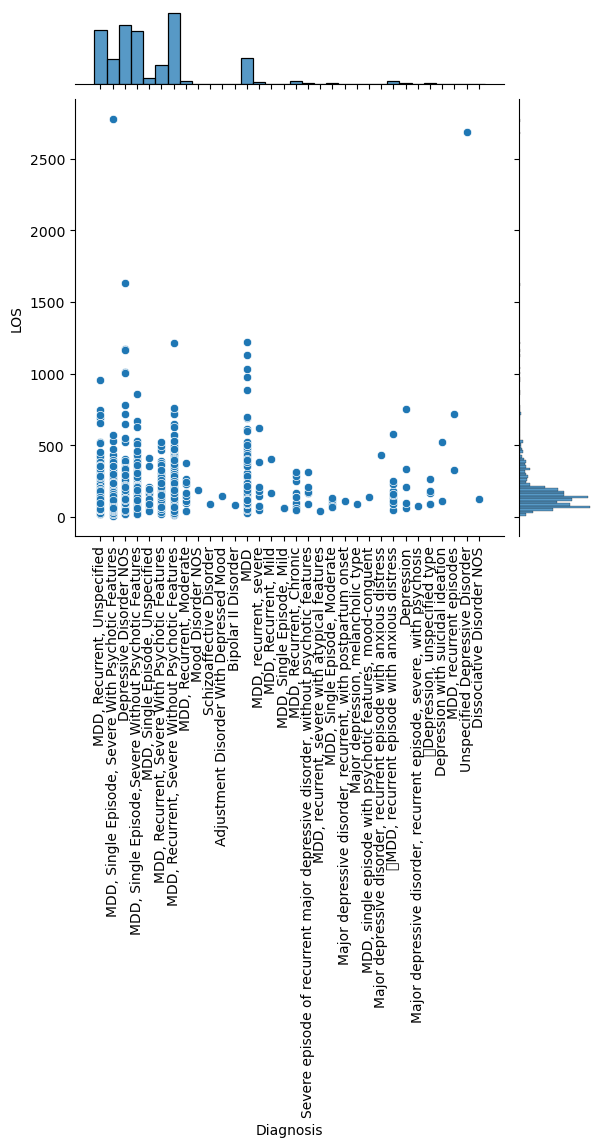

In [754]:
# Should we drop it?
sns.jointplot(data=df,x='Diagnosis',y='LOS')
plt.xticks(rotation=90);

In [755]:
from sklearn.preprocessing import OrdinalEncoder

df['Diagnosis'] = OrdinalEncoder().fit_transform(df['Diagnosis'].to_numpy().reshape(-1,1))
corr_rar = np.around(df['RAR'].corr(df['Diagnosis']),4)
corr_los = np.around(df['LOS'].corr(df['Diagnosis']),4)
print(f'RAR and Diagnosis are {corr_rar}% corr while LOS and Diagnosis are {corr_los}% correlated')

# Drop Diagnosis as it is not important to predict LOS
df.drop('Diagnosis',axis=1,inplace=True)

RAR and Diagnosis are 0.0186% corr while LOS and Diagnosis are -0.0041% correlated


In [756]:
df.groupby(['RAR']).count().transpose().head(1)

RAR,0,1
GENDER,1358,142


,LOS,Ethnicity_B,Ethnicity_L,Ethnicity_O/U,Ethnicity_W
LOS,1.000000,-0.062668,-0.118628,-0.004896,0.148104
Ethnicity_B,-0.062668,1.000000,-0.217214,-0.083441,-0.433118
Ethnicity_L,-0.118628,-0.217214,1.000000,-0.131254,-0.681301
Ethnicity_O/U,-0.004896,-0.083441,-0.131254,1.000000,-0.261716
Ethnicity_W,0.148104,-0.433118,-0.681301,-0.261716,1.000000


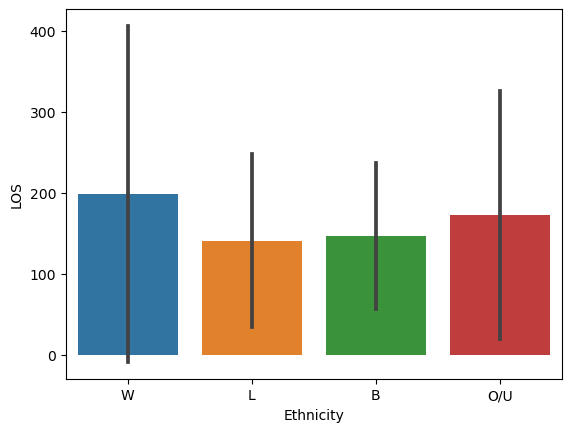

In [757]:
# Looking at more columns for influence...
# White patients tend to vary most and have on avg the majority of LOS
sns.barplot(data=df, x='Ethnicity', y='LOS', estimator=np.mean, errorbar='sd')
# However the Ethnicity coefficient is not that significant. 
race = df[['LOS','Ethnicity']]
pd.get_dummies(race).corr()

#########################
Discharged people : 1358 Recurrent people: 142 with a 9.56 times imbalance
#########################


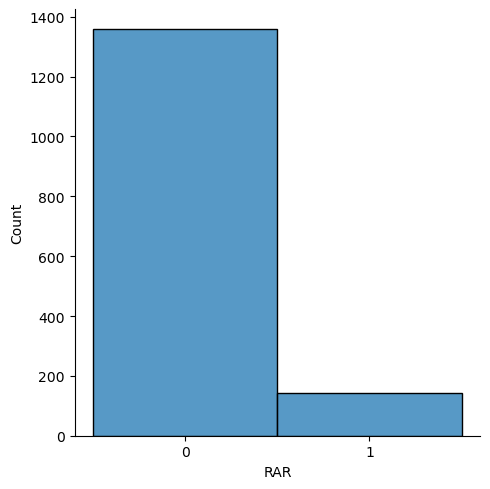

In [758]:
# Understanding what to predict: RAR or LOS ?

# Convert to string for plotting
df['RAR'] = df['RAR'].astype(str)
discharged_ppl,recurrent_ppl = df['RAR'].value_counts()
imbalance_ratio = np.around(discharged_ppl / recurrent_ppl,2)
print('#########################')
print(f'Discharged people : {discharged_ppl} Recurrent people: {recurrent_ppl} with a {imbalance_ratio} times imbalance')
print('#########################')
sns.displot(df['RAR'],bins=2)

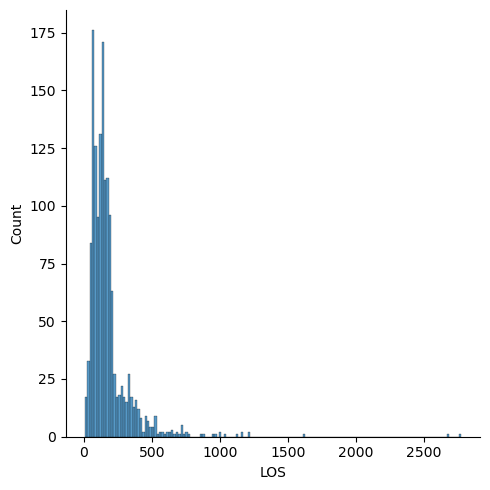

count    1500.000000
mean      176.520667
std       174.259930
min         6.000000
25%        90.000000
50%       138.000000
75%       191.250000
max      2776.000000
Name: LOS, dtype: float64


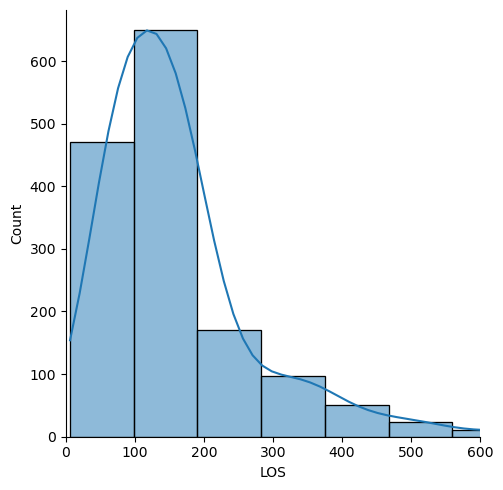

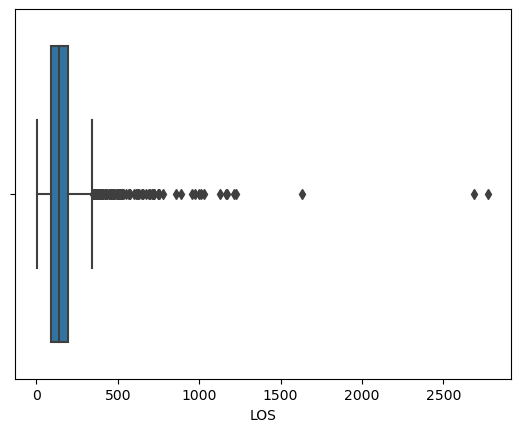

In [759]:
# Since RAR is heavely imbalanced, let's try to focus on another outcome: The Length of Stay (LOS)

sns.displot(df['LOS'])
plt.show()
# Most patients don't stay more than 200 days
print(df['LOS'].describe())
sns.displot(data=df,x='LOS',bins=30,kde=1)
plt.xlim(0,600)
plt.show()
# Possibly detecting outliers
sns.boxplot(data=df,x='LOS')
plt.show()

In [760]:
# Making sense of outliers

def convert_days(days):
    years, days = divmod(days, 365) 
    months, days = divmod(days, 30)  
    print(f'Most extreme patient spent {years} years, {months} months and {days} days in the clinic')

convert_days(df['LOS'].max())

Most extreme patient spent 7 years, 7 months and 11 days in the clinic


In [761]:
'''
The following two 'detect_outliers' functions have been taken from 'Finding an outlier in a dataset using Python' by Krish Naik.
https://www.youtube.com/embed/rzR_cKnkD18
'''
outliers = []

def detect_outliers(df):
    threshold=3 # Can change
    mean = np.mean(df)
    std = np.std(df)

    for point in df:
        z_score = (point-mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(point)
        
    return outliers

outliers_std = sorted(detect_outliers(df['LOS']))
std_df = pd.DataFrame(outliers_std,columns=['outlier'])

def detect_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

outliers_iqr = sorted(detect_outliers(df['LOS']))
iqr_df = pd.DataFrame(outliers_iqr,columns=['outlier'])

# Combined outliers
pd.concat([iqr_df,std_df]).drop_duplicates()

,outlier
0,349
1,350
2,351
3,352
4,353
...,...
137,1215
138,1223
139,1629
140,2685


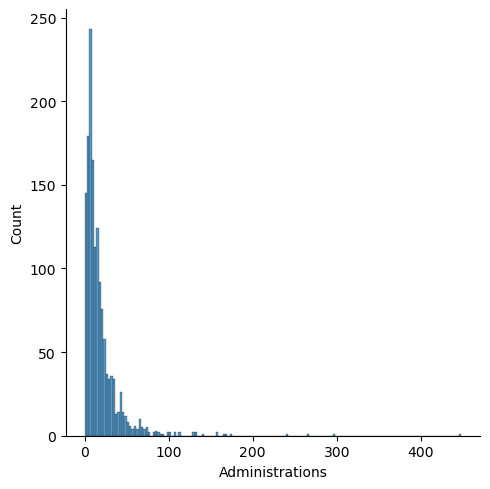

count    1500.000000
mean       18.322667
std        25.320176
min         0.000000
25%         6.000000
50%        12.000000
75%        22.000000
max       448.000000
Name: Administrations, dtype: float64


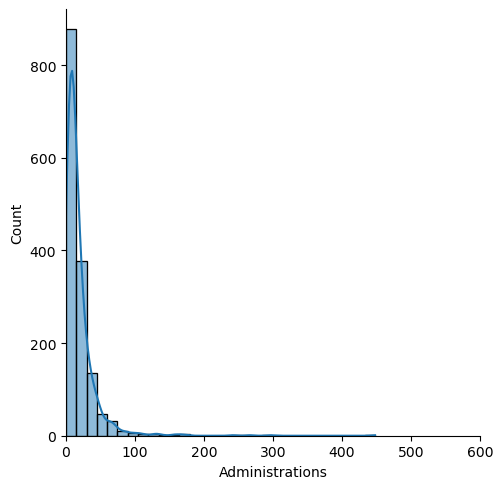

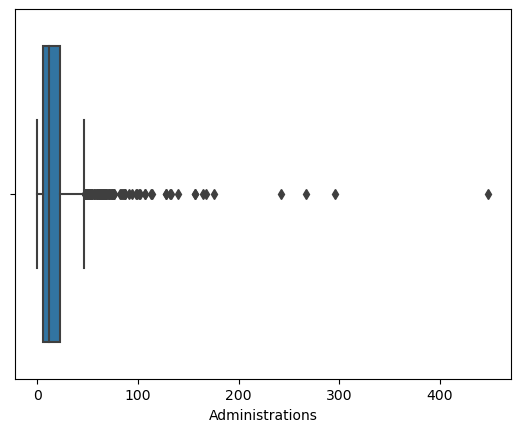

Most extreme patient had to take 448 medications


,GENDER,AGE,Ethnicity,MD,Assignment,EMR,LOS,RAR,AMITRIPTYLINE,ARIPIPRAZOLE,...,PERPHENAZINE,QUETIAPINE,RISPERIDONE,SERTRALINE,TRAZODONE,VENLAFAXINE,ZIPRASIDONE,Psychotropics,Administrations,Therapeutic Guidances
Patient,,,,,,,,,,,,,,,,,,,,,
1060,F,66,W,T,G,E,2685,0,0,12,...,0,0,0,0,111,0,0,6,448,EG


In [762]:
# Now looking at amount of drugs taken in clinic
sns.displot(df['Administrations'])
plt.show()
# Most patients don't stay more than 200 days
print(df['Administrations'].describe())
sns.displot(data=df,x='Administrations',bins=30,kde=1)
plt.xlim(0,600)
plt.show()
# Possibly detecting outliers
sns.boxplot(data=df,x='Administrations')
plt.show()
extreme_n_drugs = df['Administrations'].max()
print(f'Most extreme patient had to take {extreme_n_drugs} medications')
df[df['Administrations']==df['Administrations'].max()]

In [763]:
# Problematic columns for ML
for col in df.select_dtypes(include='object').columns:
    print(f'Column {col} has the following values:')
    print(df[col].value_counts())
    print('#########################')

# Except for the MD column, I would encourage doing a OneHotEncoding on each
# TODO solve objects

Column GENDER has the following values:
F    769
M    731
Name: GENDER, dtype: int64
#########################
Column Ethnicity has the following values:
W      864
L      382
B      182
O/U     72
Name: Ethnicity, dtype: int64
#########################
Column MD has the following values:
L    294
T    189
W    151
D    120
B    113
K    105
A    100
I     72
U     68
R     67
M     45
Q     44
F     35
G     35
O     27
N     11
J      9
V      6
P      2
C      2
H      2
E      2
S      1
Name: MD, dtype: int64
#########################
Column Assignment has the following values:
G    1023
S     477
Name: Assignment, dtype: int64
#########################
Column EMR has the following values:
C    856
E    644
Name: EMR, dtype: int64
#########################
Column RAR has the following values:
0    1358
1     142
Name: RAR, dtype: int64
#########################
Column Therapeutic Guidances has the following values:
EG    1041
CT     393
TL      66
Name: Therapeutic Guidances, dtyp

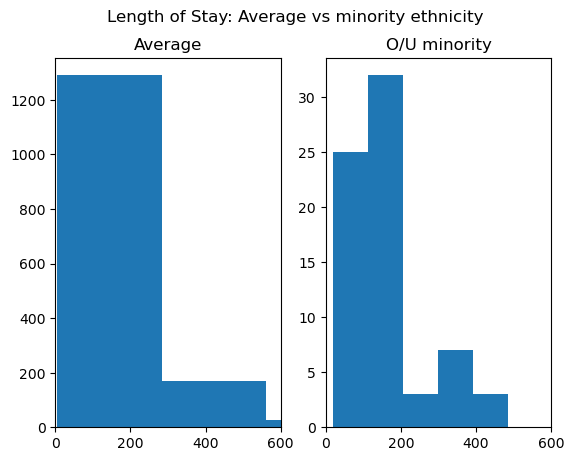

<Axes: xlabel='Ethnicity', ylabel='LOS'>

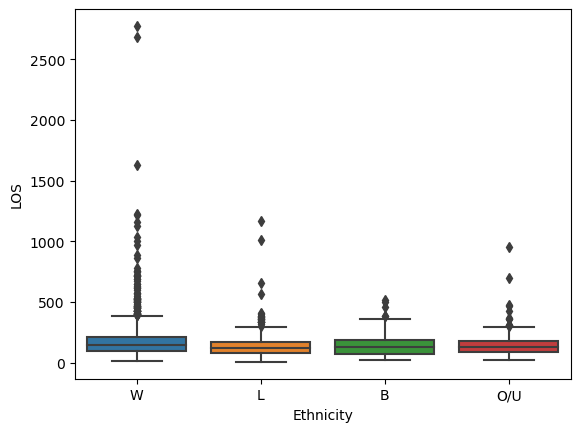

In [764]:
fig, ax = plt.subplots(ncols=2,nrows=1)
ax[0].hist(df['LOS'])
ax[0].set_xlim([0, 600])
ax[0].set_title('Average')
ax[1].hist(df[df['Ethnicity']=='O/U']['LOS'])
ax[1].set_title('O/U minority')
ax[1].set_xlim([0, 600])
fig.suptitle('Length of Stay: Average vs minority ethnicity')
plt.show()
sns.boxplot(x='Ethnicity',y='LOS',data=df)
# Since there is not much variance I decided to keep it

<Axes: xlabel='LOS', ylabel='Administrations'>

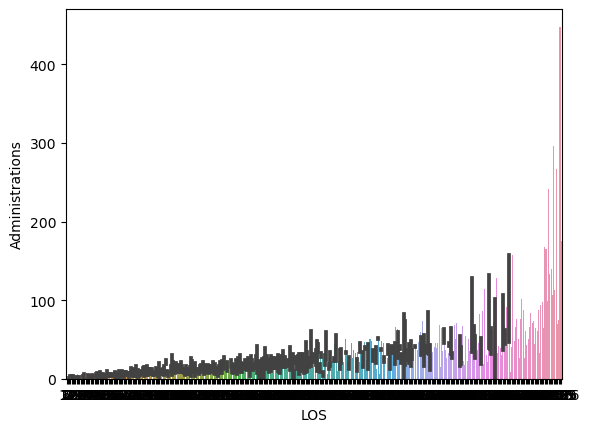

In [769]:
# Here we cannot see the number of people who fall into these ranges but rather only how total drug intake + days in clinic are  correlated
sns.barplot(data=df,x='LOS',y='Administrations')

C:\Users\W\AppData\Local\Temp\ipykernel_5004\393060756.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cols = df.corr().nlargest(26, 'LOS')['LOS'].sort_values(ascending=False).index


<Axes: >

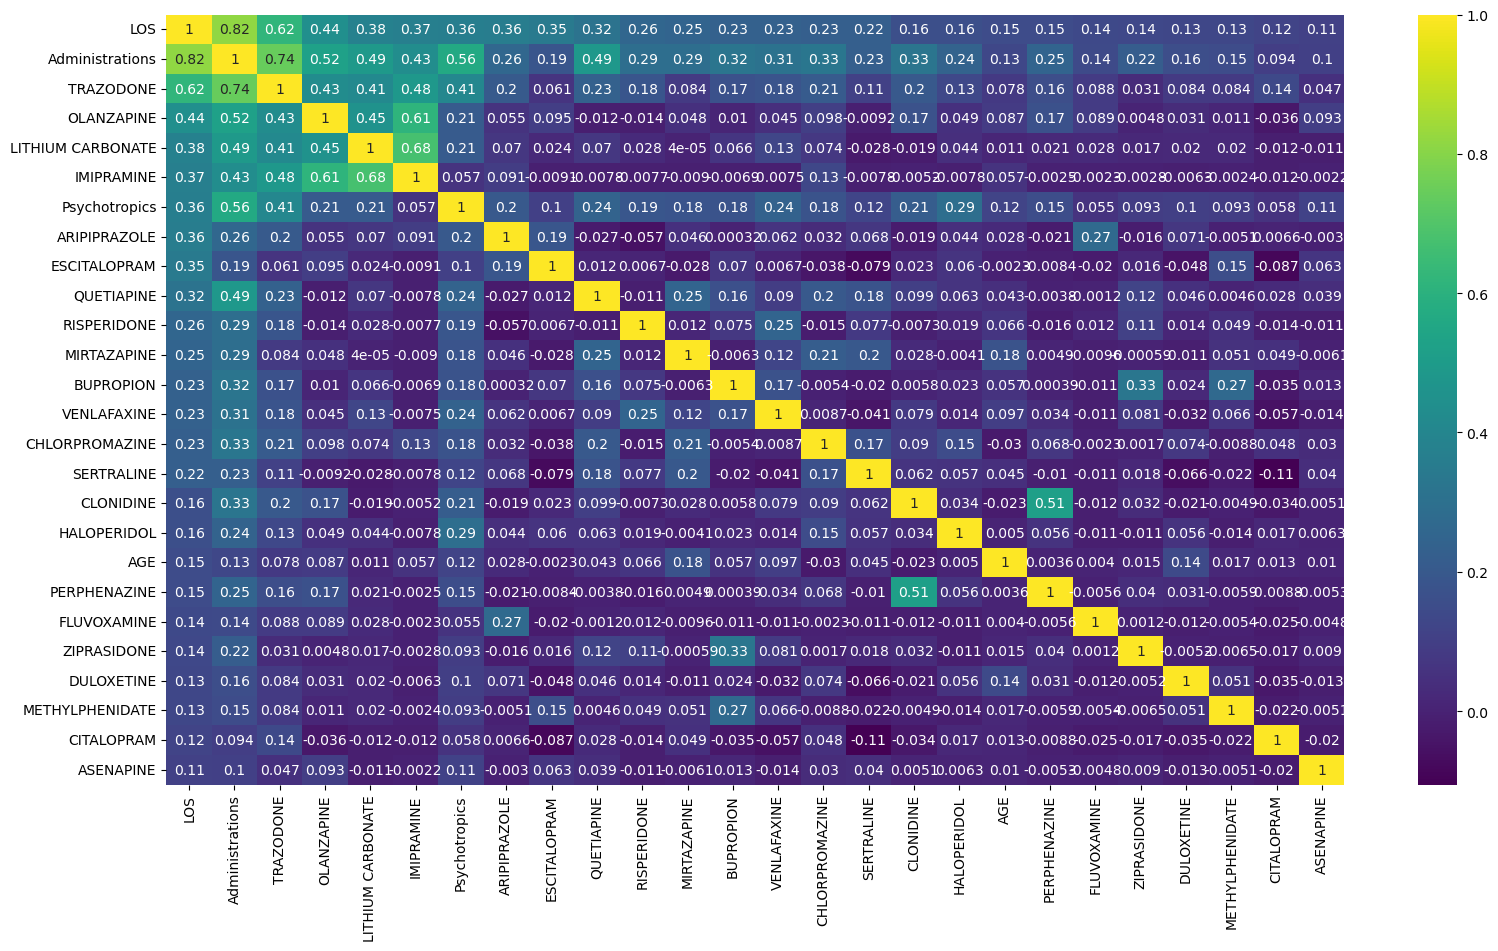

In [766]:
# There seems to be a correlation between the length of stay (LOS) and the amount of medications patients had to take
# Let's corroborate that presumption by plotting a heatmap!

plt.figure(figsize=(19,10),dpi=100)
cols = df.corr().nlargest(26, 'LOS')['LOS'].sort_values(ascending=False).index
sns.heatmap(df[cols].corr(),annot=True,cmap='viridis')

In [767]:
# Too many features, isn't it? 

def clean_useless_cols(df, y_label):
    print('#########################')
    print(f'starting with {df.columns.size} cols')
    print('#########################')
    print(df.corr().nlargest(df.columns.size, y_label)
          [y_label].sort_values(ascending=True))
    irrelevant_cols = pd.DataFrame(df.corr()[y_label]).isna()
    ir_cols_list = irrelevant_cols[irrelevant_cols[y_label]].index
    print('\n#########################')
    print('irrelevant cols found (constants):')
    print('#########################')
    print(df[ir_cols_list].nunique())
    df.drop(ir_cols_list, axis=1, inplace=True)
    print('\n#########################')
    print(f'voila! set cleared. {df.columns.size} cols left to work with')
    print('#########################')

clean_useless_cols(df,'LOS')

#########################
starting with 41 cols
#########################
GUANFACINE           0.001724
PALIPERIDONE         0.024403
NORTRIPTYLINE        0.026556
FLUPHENAZINE         0.029459
AMITRIPTYLINE        0.036447
CLOMIPRAMINE         0.047341
FLUOXETINE           0.082462
DOXEPIN              0.087144
ASENAPINE            0.106835
CITALOPRAM           0.116268
METHYLPHENIDATE      0.129360
DULOXETINE           0.131695
ZIPRASIDONE          0.135403
FLUVOXAMINE          0.137158
PERPHENAZINE         0.145510
AGE                  0.147532
HALOPERIDOL          0.161150
CLONIDINE            0.161729
SERTRALINE           0.224537
CHLORPROMAZINE       0.226388
VENLAFAXINE          0.231670
BUPROPION            0.234516
MIRTAZAPINE          0.247004
RISPERIDONE          0.257082
QUETIAPINE           0.316571
ESCITALOPRAM         0.345968
ARIPIPRAZOLE         0.358304
Psychotropics        0.362663
IMIPRAMINE           0.368087
LITHIUM CARBONATE    0.377044
OLANZAPINE           0.438

C:\Users\W\AppData\Local\Temp\ipykernel_5004\691254445.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr().nlargest(df.columns.size, y_label)
C:\Users\W\AppData\Local\Temp\ipykernel_5004\691254445.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  irrelevant_cols = pd.DataFrame(df.corr()[y_label]).isna()


In [771]:
n_leftover_patients = df[df['LOS']<=outliers_std[0]].to_numpy().shape[0]
n_starting_patients = df.shape[0]

percentage = (n_leftover_patients / n_starting_patients) * 100
print("Std-Drop: Percentage of patients retained: {:.2f}%".format(percentage))

n_leftover_patients = df[df['LOS']<=outliers_iqr[0]].to_numpy().shape[0]
n_starting_patients = df.shape[0]

percentage = (n_leftover_patients / n_starting_patients) * 100
print("IQR-Drop: Percentage of patients retained: {:.2f}%".format(percentage))

# Considering ... I have opted for dropping outliers above the value given by the x1.5 IQR calculation
# TODO .mode() replacement worth it?
# Drop the columns
df.drop(df[df['LOS'] > outliers_iqr[0]].index,inplace=True)
print(f"Now set has {df.shape[0]} patients")

Std-Drop: Percentage of patients retained: 100.00%
IQR-Drop: Percentage of patients retained: 100.00%
Now set has 1359 patients


# WIP

In [773]:
# Given the analysis above, let's try to solve this problem the simplest way: 
simplest_df = df[['LOS','Administrations']]
simplest_df.head()

,LOS,Administrations
Patient,,
1,70,6
2,309,27
4,115,14
5,120,11
6,120,13


In [774]:
clf = LinearRegression()

X = simplest_df.drop('LOS', axis=1)
y = simplest_df['LOS'].to_numpy()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=SEED, shuffle=True, test_size=0.3)

clf.fit(X_train, y_train)
yhat = clf.predict(X_test)
mae = mean_absolute_error(y_test,yhat)

cscores = cross_validate(
    clf, X_train, y_train, scoring='neg_mean_absolute_error', cv=LeaveOneOut())


cv_mae = abs(cscores['test_score'].mean())
mae,cv_mae

(37.64017538069997, 41.008603247786354)

In [530]:
# Let's get our hands dirty
clf = ElasticNetCV(random_state=SEED)


OG_X = df.drop('LOS', axis=1)

DummyX = pd.get_dummies(OG_X,drop_first=True)
y = df['LOS'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    DummyX, y, random_state=SEED, shuffle=1, test_size=0.3)

In [531]:
DummyX.columns
# TODO continue cleaning OR feed to ensemble / nn

Index(['AGE', 'RAR', 'AMITRIPTYLINE', 'ARIPIPRAZOLE', 'ASENAPINE', 'BUPROPION',
       'CHLORPROMAZINE', 'CITALOPRAM', 'CLOMIPRAMINE', 'CLONIDINE', 'DOXEPIN',
       'DULOXETINE', 'ESCITALOPRAM', 'FLUOXETINE', 'FLUPHENAZINE',
       'FLUVOXAMINE', 'GUANFACINE', 'HALOPERIDOL', 'IMIPRAMINE',
       'LITHIUM CARBONATE', 'METHYLPHENIDATE', 'MIRTAZAPINE', 'NORTRIPTYLINE',
       'OLANZAPINE', 'PALIPERIDONE', 'PERPHENAZINE', 'QUETIAPINE',
       'RISPERIDONE', 'SERTRALINE', 'TRAZODONE', 'VENLAFAXINE', 'ZIPRASIDONE',
       'Psychotropics', 'Administrations', 'GENDER_M', 'Ethnicity_L',
       'Ethnicity_O/U', 'Ethnicity_W', 'MD_B', 'MD_C', 'MD_D', 'MD_E', 'MD_F',
       'MD_G', 'MD_H', 'MD_I', 'MD_J', 'MD_K', 'MD_L', 'MD_M', 'MD_N', 'MD_O',
       'MD_P', 'MD_Q', 'MD_R', 'MD_S', 'MD_T', 'MD_U', 'MD_V', 'MD_W',
       'Assignment_S', 'EMR_E', 'Therapeutic Guidances_EG',
       'Therapeutic Guidances_TL'],
      dtype='object')

In [532]:
# Possible feature selection

# KBest
skb = SelectKBest(chi2, k=5).fit(X_train, y_train)
# Recurrent Feature Extraction 
rfe = RFE(clf,step=1).fit(X_train,y_train)
# Recurrent Feature Extraction with Cross-Validation
rfecv = RFECV(clf,step=1,scoring='neg_mean_squared_error',cv=5).fit(X_train,y_train)

SKBX_train = skb.transform(X_train)
SKBX_test = skb.transform(X_test)
pd.DataFrame({'ft': DummyX.columns, 'score': skb.scores_}
             ).sort_values('score', ascending=0)
print(f'SKB OG ft: {X_train.shape[1:]} | best ft: {SKBX_train.shape[1:]}')

RFEX_train = rfe.transform(X_train)
RFEX_test = rfe.transform(X_test)
rfe_df = pd.DataFrame({'ft':DummyX.columns,'ranking':rfe.ranking_}).sort_values('ranking')
keep_ft = rfe_df.loc[rfe_df['ranking']<2,'ranking'].count()
print(f'RFE now considering {keep_ft} cols')

RFECVX_train = rfecv.transform(X_train)
RFECVX_test = rfecv.transform(X_test)
print(f'RFECV says {X_train.columns[rfecv.support_]} ({rfecv.n_features_}) as best ft\'s to keep')

SKB OG ft: (64,) | best ft: (5,)
RFE now considering 32 cols
RFECV says Index(['AGE', 'AMITRIPTYLINE', 'ARIPIPRAZOLE', 'ASENAPINE', 'BUPROPION',
       'CITALOPRAM', 'CLOMIPRAMINE', 'CLONIDINE', 'DOXEPIN', 'DULOXETINE',
       'ESCITALOPRAM', 'FLUOXETINE', 'FLUVOXAMINE', 'HALOPERIDOL',
       'LITHIUM CARBONATE', 'MIRTAZAPINE', 'OLANZAPINE', 'PALIPERIDONE',
       'PERPHENAZINE', 'QUETIAPINE', 'RISPERIDONE', 'SERTRALINE', 'TRAZODONE',
       'VENLAFAXINE', 'ZIPRASIDONE', 'Psychotropics', 'Administrations',
       'GENDER_M', 'Ethnicity_L', 'Ethnicity_W', 'MD_L', 'MD_T', 'EMR_E'],
      dtype='object') (33) as best ft's to keep


Text(0.5, 0, 'ft')

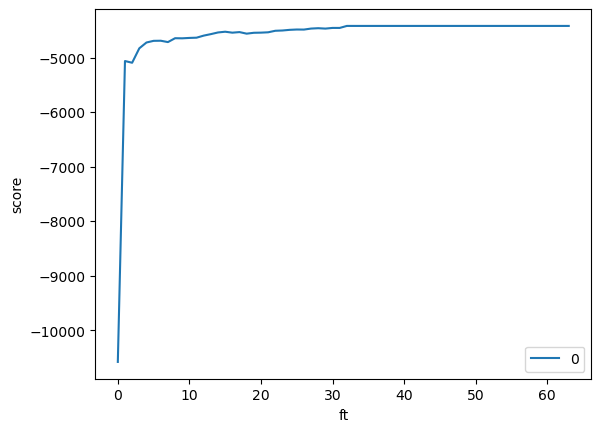

In [533]:
import numpy as np
# Understanding where RFE CV stopped
dfplot = pd.DataFrame(rfecv.cv_results_['mean_test_score']).plot()
# dfplot.set_xlim((0,16))
dfplot.set_ylabel('score')
dfplot.set_xlabel('ft')

In [534]:
# Vanilla
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(mae,rmse)

# RFE
clf.fit(RFEX_train,y_train)
y_pred = clf.predict(RFEX_test)
# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(mae,rmse)

# SKB
clf.fit(SKBX_train,y_train)
y_pred = clf.predict(SKBX_test)
# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(mae,rmse)

45.81291527362758 64.32134723101103
45.81046453195779 64.3203679753904
51.74321957064864 73.89637469438338


Text(0, 0.5, 'y_pred')

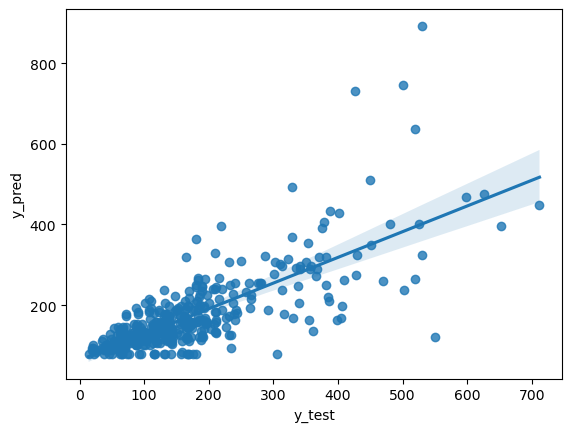

In [535]:
# TODO fix bc this shows SKB only
sns.regplot(x=y_test,y=y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')

In [536]:
# Lastly let's try PCA for dimensionality reduction
pca = PCA(n_components=2).fit(X_train)
PCAX_train = pca.transform(X_train)
PCAX_test = pca.transform(X_test)

clf.fit(PCAX_train,y_train)
y_pred = clf.predict(PCAX_test)
# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(mae,rmse)

# Only 2 combined ft seems to work great compared to SKB!

51.16551715651106 73.14887802231372


In [537]:
'''ERRORS encountered on the way:

- The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
Solution: Combine values so you don't end up with single y datapoint labels for very similar ranges OR don't use stratify during split!


- Getting low accuracy on a regression problem: Solution : Use MAE RMSE

- SimpleImputer for NaN causes loss of types when reconstructing to DataFrame
'''

"ERRORS encountered on the way:\n\n- The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.\nSolution: Combine values so you don't end up with single y datapoint labels for very similar ranges OR don't use stratify during split!\n\n\n- Getting low accuracy on a regression problem: Solution : Use MAE RMSE\n"

# Models

In [538]:
# Define the hyperparameter search space
param_grid = {
    'hidden_layer_sizes': (randint(10, 200).rvs(),randint(10, 200).rvs()),
    'max_iter': randint(2, 10000),
}

# Instantiate the model and the random search
clf = MLPRegressor(random_state=SEED,solver='adam')
random_search = RandomizedSearchCV(clf, param_grid, n_iter=10, cv=5, random_state=SEED)

df = pd.read_csv('Dataset.csv',encoding='utf-8')

X = pd.get_dummies(df.drop('LOS',axis=1),drop_first=True)
y = df['LOS']

# Fit the random search to the data
random_search.fit(X, y)

c:\Users\W\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (468) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\W\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (468) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\W\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (468) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\W\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (468) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\W\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:

RandomizedSearchCV(cv=5, estimator=MLPRegressor(random_state=101),
                   param_distributions={'hidden_layer_sizes': (175, 137),
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C7EFF99FC0>},
                   random_state=42)

In [540]:
print("Best Hyperparameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)


Best Hyperparameters:  {'hidden_layer_sizes': 137, 'max_iter': 468}
Best Score:  0.6366616780173322
